In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gp_likelihood import GaussianProcesses as GP
from gp_likelihood import min_GaussianProcesses as mGP
from gp_likelihood import rec_GaussianProcesses as rGP
from gp_likelihood import rec_extern_GaussianProcesses as rexGP
from gapp import dgp

import time
from multiprocessing.dummy import Pool as Pool

In [2]:
%load_ext cython

In [26]:
%%cython --cplus --compile-args=-fopenmp --link-args=-fopenmp

from cython.parallel import prange#, Py_size_t
from cython.operator import postincrement as postIncr
import numpy as np
cimport numpy as np
from gp_likelihood import GaussianProcesses as GP
from gp_likelihood import min_GaussianProcesses as mGP
from gp_likelihood import rec_GaussianProcesses as rGP
from gp_likelihood import rec_extern_GaussianProcesses as rexGP
from multiprocessing import Pool as Pool, cpu_count

cpdef double[:] get_hyper_pars(double[:] X, double[:] Y, double[:,:] Cov):
    gpY = mGP(X,Y,Cov)
    res = gpY.min_loglikelihood()
    print(res)
    return res.x

cpdef double[:] rec_int_dzdmu(double[:] z, double[:] X, double[:] Y, double[:,:] Cov,
                               double sigf, double lenf):
    cdef int n, i
    #cdef Py_size_t j
    cdef double[:] rec
    
    n = z.shape[0]
    rec = np.zeros(n)
    gp = rexGP(X,Y,Cov,sigf,lenf)
    
    for i in range(n):
        rec[i] = gp.integrate_one_over_mu(z[i])
    return rec

cpdef rec_int_dzdmu_p(double[:] z, double[:] rec, double[:] X, double[:] Y, double[:,:] Cov,
                               double sigf, double lenf):
    cdef int n
    cdef Py_ssize_t i
    
    gp = rexGP(X,Y,Cov,sigf,lenf)
    
    for i in prange(n, nogil=True):
        rec[i] = gp.integrate_one_over_mu(z[i])
    return

#def process_rec_int(zi, gp):
#    return gp.integrate_one_over_mu(zi)

#def rec_int_dzdm_pool(double[:] z, double[:] X, double[:] Y, double[:,:] Cov,
#                               double sigf, double lenf):
#    cdef int cores, i, j, n
#    cdef list p_list
#    
#    cores = cpu_count()
#    pool = Pool(cores)
#    n = z.shape[0]
#    gp = rexGP(X,Y,Cov,sigf,lenf)
#    
#    p_list = []
#    for i in range(n):
#        pp = pool.apply_async(process_rec_int, args=(z[i], gp))
#        p_list.append(pp)
#    result = [pp.get() for pp in p_list]
#    pool.close()
#    pool.join()
#    return result


Error compiling Cython file:
------------------------------------------------------------
...
    cdef Py_ssize_t i
    
    gp = rexGP(X,Y,Cov,sigf,lenf)
    
    for i in prange(n, nogil=True):
        rec[i] = gp.integrate_one_over_mu(z[i])
                                        ^
------------------------------------------------------------

/home/ekli/.cache/ipython/cython/_cython_magic_0560a0e3dd1203b28d1a872d3c0eb8f6.pyx:40:41: Coercion from Python not allowed without the GIL

Error compiling Cython file:
------------------------------------------------------------
...
    cdef Py_ssize_t i
    
    gp = rexGP(X,Y,Cov,sigf,lenf)
    
    for i in prange(n, nogil=True):
        rec[i] = gp.integrate_one_over_mu(z[i])
                                        ^
------------------------------------------------------------

/home/ekli/.cache/ipython/cython/_cython_magic_0560a0e3dd1203b28d1a872d3c0eb8f6.pyx:40:41: Calling gil-requiring function not allowed without gil

Error compiling

TypeError: object of type 'NoneType' has no len()

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#rec_dat = np.loadtxt('/home/ekli/myworks/cosmodata/Growth_tableII.txt', unpack=True)
rec_dat = np.loadtxt('/home/ekli/myworks/cosmodata/CC_31.txt', unpack=True)
X = rec_dat[0]
Y = rec_dat[1]
err = rec_dat[2]
cov = np.eye(len(err))*err**2

gpY = mGP(X,Y,cov)

print('~'*30)
%time res = gpY.min_loglikelihood()
print(res)
#print(res.x)

print('~'*30)

%time theta = get_hyper_pars(X,Y,cov)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CPU times: user 1.16 s, sys: 123 ms, total: 1.28 s
Wall time: 168 ms
      fun: 132.19245072113145
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.52651283e-06, -1.70530257e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 66
      nit: 20
   status: 0
  success: True
        x: array([133.80863893,   1.93610328])
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
      fun: 132.19245072113145
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.52651283e-06, -1.70530257e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 66
      nit: 20
   status: 0
  success: True
        x: array([133.80863893,   1.93610328])
CPU times: user 1.21 s, sys: 105 ms, total: 1.32 s
Wall time: 165 ms


In [14]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# reconst \int_0^x 1/mu(x) dx

sigf, lenf = res.x
gp = rexGP(X,Y,cov,sigf,lenf)

z = np.linspace(0,2,41)

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
print('The start time is: %s'%time.asctime())
s_time = time.perf_counter()
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

%time rec_int1 = np.array([gp.integrate_one_over_mu(zi,0.0) for zi in z])
%time rec_int2 = rec_int_dzdmu(z,X,Y,cov,sigf,lenf)
#%time rec_int3 = rec_int_dzdm_pool(z,X,Y,cov,sigf,lenf)

The start time is: Fri May  3 21:11:02 2019
CPU times: user 825 ms, sys: 71.8 ms, total: 897 ms
Wall time: 112 ms
CPU times: user 849 ms, sys: 69.8 ms, total: 919 ms
Wall time: 115 ms


      fun: 132.19245072113145
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.52651283e-06, -1.70530257e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 66
      nit: 20
   status: 0
  success: True
        x: array([133.80863893,   1.93610328])
[133.80863893   1.93610328]
The start time is: Fri May  3 20:16:39 2019
Using time 8.101997204998042 s
The start time is: Fri May  3 20:16:47 2019
Using time 8.160254414993688 s
The start time is: Fri May  3 20:16:55 2019
Using time 13.63712781999493 s


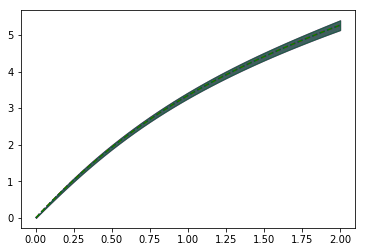

In [2]:

sig_int_dzdmu = np.array([gp.Cov_integrate_one_over_mu(zi,zi,0) for zi in z])

#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
e_time = time.perf_counter()
print('Using time %s s'%(e_time - s_time))
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
print('The start time is: %s'%time.asctime())
s_time = time.perf_counter()
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

rec_int_dzdmu1 = np.array([gp.integrate_f_mu_x(zi,0.0,-1,0) for zi in z])
sig_int_dzdmu1 = np.array([gp.Cov_integrate_f_mu_x(zi,zi,0,-1,0) for zi in z])

#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
e_time = time.perf_counter()
print('Using time %s s'%(e_time - s_time))
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
print('The start time is: %s'%time.asctime())
s_time = time.perf_counter()
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Afunc = lambda x: 1.0
Bfunc = lambda x: 1.0
bet = 0.0
alp = -1.0

rec1 = np.array([gp.integrate_f_pq_x(Afunc,Bfunc,zi,0.0,alp,bet) for zi in z])
sigsq1 = np.array([gp.Cov_integrate_f_pq_x(Afunc,Bfunc,zi,zi,0.0,alp,bet) for zi in z])
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
e_time = time.perf_counter()
print('Using time %s s'%(e_time - s_time))
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

ff = rec_int_dzdmu*300
sig = np.sqrt(sig_int_dzdmu)*300

ff1 = rec_int_dzdmu1*300
sig1 = np.sqrt(sig_int_dzdmu1)*300

plt.figure()

plt.plot(z, ff, '--r')
plt.fill_between(z, ff+sig, ff-sig, color='red', alpha=0.5)

plt.plot(z, ff1, ':b')
plt.fill_between(z, ff1+sig1, ff1-sig1, color='blue', alpha=0.5)

ff = rec1*300
sig = np.sqrt(sigsq1)*300

plt.plot(z, ff, '--g')
plt.fill_between(z, ff+sig, ff-sig, color='green', alpha=0.5)

plt.show()

In [25]:
import cython.parallel as multi
help(multi.prange)

Help on method prange in module Cython.Shadow:

prange(start=0, stop=None, step=1, schedule=None, nogil=False) method of Cython.Shadow.CythonDotParallel instance



In [19]:
def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt
    

In [21]:
b = 0.25
c = 5.0
t = np.linspace(0, 10, 101)
y0 = [np.pi - 0.1, 0.0]
sol = integrate.odeint(pend, y0, t, args=(b, c))

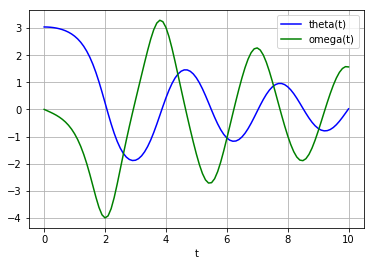

In [22]:
plt.plot(t, sol[:, 0], 'b', label='theta(t)')
plt.plot(t, sol[:, 1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [79]:
class general_dark:
    def __init__(self,omc,omv,wx,xic,xix):
        self.omc = omc
        self.omv = omv
        self.wx=wx
        self.xic=xic
        self.xix=xix
        return
    
    def xi(self,rc,rx):
        return self.xic *self.omc *rc +self.xix*self.omv*rx
    
    def derive(self,y0,x):
        yp = np.zeros(len(y0))
        rc = np.exp(y0[0])
        rx = np.exp(y0[1])
        yp[0] = -3 - 3*self.xi(rc,rx)/self.omc /rc
        yp[1] = -3*(1+self.wx)+3*self.xi(rc,rx)/self.omv /rx
        return yp
    
    def derive_z(self,y,z):
        yp = np.zeros(len(y0))
        yp[0] = 3 *y[0] + 3*self.xi(y[0],y[1])/self.omc
        yp[1] = 3*(1+self.wx)*y[0] -3*self.xi(y[0],y[1])/self.omv
        return yp/(1+z)
    
    def derive_lz(self,y,z):
        yp = np.zeros(len(y0))
        rc = np.exp(y0[0])
        rx = np.exp(y0[1])
        yp[0] = 3 *y[0] + 3*self.xi(rc,rx)/self.omc/rc
        yp[1] = 3*(1+self.wx)*y[0] -3*self.xi(rc,rx)/self.omv/rx
        return yp/(1+z)
    
    def derive_nx(self,y0,x):
        yp = np.zeros(len(y0))
        rc = np.exp(y0[0])
        rx = np.exp(y0[1])
        yp[0] = 3 + 3*self.xi(rc,rx)/self.omc /rc
        yp[1] = 3*(1+self.wx) -3*self.xi(rc,rx)/self.omv /rx
        return yp
     
    def E2ofx(self,rc,rx):
        return self.omc*rc + self.omv*rx

In [80]:
omc,omv,wx,xic,xix = np.array([0.3,0.7,-1.1,0.0,0.0])

x = np.linspace(-7.7,0,101)
y0 = [-3*x[0],-3*(1+wx)*x[0]]

dk = general_dark(omc,omv,wx,xic,xix)

sol = integrate.odeint(dk.derive, y0, x)

y0 = [1.0,1.0]
z = np.sort(np.exp(-x)-1)
solz = integrate.odeint(dk.derive_z, y0, z)

y0 = [0.0,0.0]
z = np.sort(np.exp(-x)-1)
sollz = integrate.odeint(dk.derive_lz, y0, z)

y0 = [1.0,1.0]
nx = np.linspace(0,7.7,101)
soln = integrate.odeint(dk.derive_nx, y0, nx)

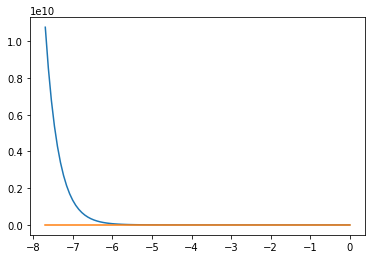

In [81]:
plt.plot(x, np.exp(sol.T[0]))
plt.plot(x, np.exp(sol.T[1]))

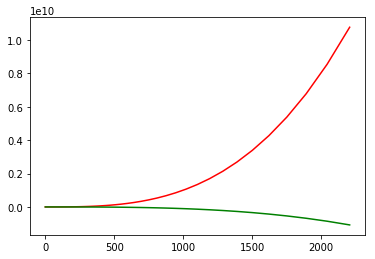

In [82]:
plt.plot(z, solz.T[0], 'r')
plt.plot(z, solz.T[1], 'g')


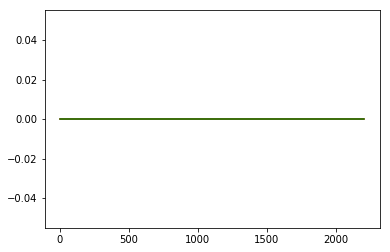

In [83]:
plt.plot(z, sollz.T[0], 'r')
plt.plot(z, sollz.T[1], 'g')

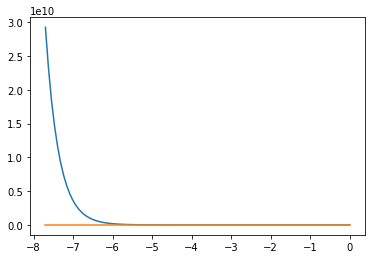

In [75]:
plt.plot(-nx, np.exp(soln.T[0]))
plt.plot(-nx, np.exp(soln.T[1]))

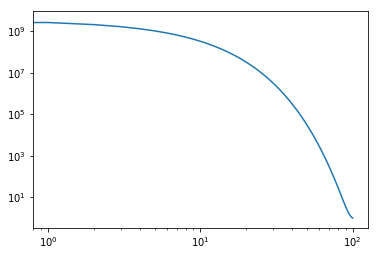

In [76]:
plt.plot(dk.E2ofx(np.exp(sol.T[0]),np.exp(sol.T[1])))
plt.xscale('log')
plt.yscale('log')

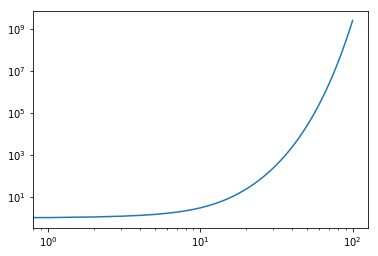

In [77]:
plt.plot(dk.E2ofx(solz.T[0],solz.T[1]))
plt.xscale('log')
plt.yscale('log')

In [193]:
omm = 0.3
omx = 0.7
w = -1.2
xic = 0.01
xix = 0.0
xi = 0.1

ff = lambda y,z: 3*y/(1+z)
ffx = lambda y,z: 3*(1+w)*y/(1+z)

def ffs(y,z):
    ypc = 3*y[0]/(1+z)
    ypx = 3*(1+w)*y[1]/(1+z)
    return np.array([ypc,ypx])

def ffs_in(y,z):
    ypc = 3*y[0]/(1+z) +3*(xic*omm*y[0]+xix*omx*y[1])/omm/(1+z)
    ypx = 3*(1+w)*y[1]/(1+z)-3*(xic*omm*y[0]+xix*omx*y[1])/omx/(1+z)
    return np.array([ypc,ypx])

def ffs_in(y,z):
    ypc = 3*y[0]/(1+z) +3*(xic*omm*y[0]+xix*omx*y[1])/omm/(1+z)
    ypx = 3*(1+w)*y[1]/(1+z)-3*(xic*omm*y[0]+xix*omx*y[1])/omx/(1+z)
    return np.array([ypc,ypx])

def ffs_new(y,z):
    flu = 3*xi *y[1]/y[0] *(omm*y[0]+omx*y[1])
    ypc = 3*y[0]/(1+z) +flu/omm/(1+z)
    ypx = 3*(1+w)*y[1]/(1+z)-flu/omx/(1+z)
    return np.array([ypc,ypx])

x = np.linspace(-7.7,0.,101)
z = np.sort(np.exp(-x)-1)

y0 = 1
sol = integrate.odeint(ff, y0, z)
solx = integrate.odeint(ffx, y0, z)

y0s = [1,1]
sols = integrate.odeint(ffs, y0s, z)

y0s = [1,1]
sols_in = integrate.odeint(ffs_in, y0s, z)

y0s = [1,1]
sols_new = integrate.odeint(ffs_new, y0s, z)

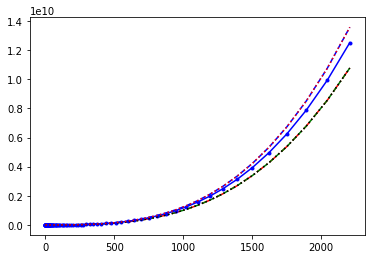

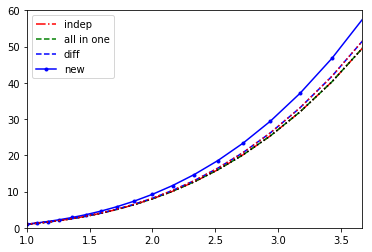

In [205]:
plt.figure()

plt.plot(1+z, sol, 'r-.')
plt.plot(1+z, sols.T[0], '--g')
plt.plot(1+z, sols_in.T[0], '--b')

plt.plot(1+z, sols_new.T[0], '.-b')

plt.plot(1+z, (1+z)**3, ':k')
plt.plot(1+z, (1+z)**(3*(1+xic)), ':r')

plt.figure()
plt.plot(1+z, sol, 'r-.')
plt.plot(1+z, sols.T[0], '--g')
plt.plot(1+z, sols_in.T[0], '--b')

plt.plot(1+z, sols_new.T[0], '.-b')

plt.plot(1+z, (1+z)**3, ':k')
plt.plot(1+z, (1+z)**(3*(1+xic)), ':r')

plt.xlim(1+z[0],z[20])
plt.ylim(0, 60)
#plt.xscale('log')

plt.legend(loc='best', labels=['indep', 'all in one', 'diff', 'new'])


In [203]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Places a legend on the axes.
    
    Call signatures::
    
        legend()
        legend(labels)
        legend(handles, labels)
    
    The call signatures correspond to three different ways how to use
    this method.
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line.set_label('Label via method')
        line, = ax.plot([1, 2, 3])
        ax.legend()
    
    Specific lines can be excluded from the automatic legend element
    selection by defining a label s

(-1, 1)

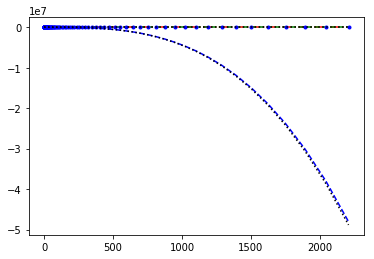

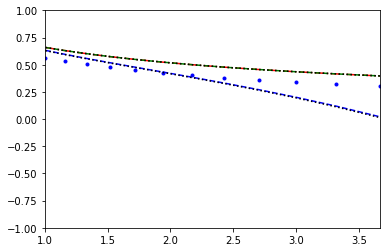

In [200]:
plt.figure()

plt.plot(z, solx, 'r-.')
plt.plot(z, sols.T[1], '--g')
plt.plot(z, sols_in.T[1], '--b')
plt.plot(z, sols_new.T[1], '.b')
plt.plot(z, (1+z)**(3*(1+w)), ':k')
plt.plot(z, (1+z)**(3*(1+w))+1/omx*3*xic/(3*xic+3*w)*omm*(1+z)**(3*(1+xic)), ':k')

plt.figure()

plt.plot(z, solx, 'r-.')
plt.plot(z, sols.T[1], '--g')
plt.plot(z, sols_in.T[1], '--b')
plt.plot(z, sols_new.T[1], '.b')
plt.plot(z, (1+z)**(3*(1+w)), ':k')
plt.plot(z, (1+z)**(3*(1+w))+1/omx*3*xic/(3*xic+3*w)*omm*(1+z)**(3*(1+xic)), ':k')

plt.xlim(1+z[0],z[20])
plt.ylim(-1, 1)

(0, 20)

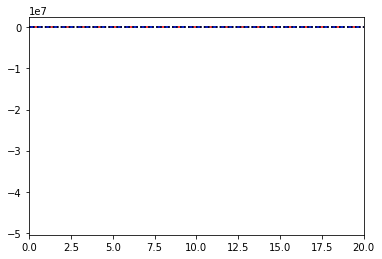

In [196]:
plt.plot(z, solx, 'r-.')
plt.plot(z, sols.T[1], '--g')
plt.plot(z, sols_in.T[1], '--b')
plt.plot(z, (1+z)**(3*(1+w)), ':k')

plt.xlim(0,20)

In [207]:
xx = np.linspace(-13.4,0.0,1001)
zz = np.sort(np.exp(-xx)-1)

zz

array([0.00000000e+00, 1.34901824e-02, 2.71623497e-02, ...,
       6.42549055e+05, 6.51217173e+05, 6.60002225e+05])

In [208]:
zz[:10]

array([0.        , 0.01349018, 0.02716235, 0.04101896, 0.05506249,
       0.06929548, 0.08372047, 0.09834006, 0.11315686, 0.12817355])

In [209]:
np.log(1e-8)

-18.420680743952367